<a href="https://colab.research.google.com/github/heerakesavan/CE888-Data-Science-and-Decision-making/blob/Master/Hate_CE888_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,confusion_matrix
import re
import gensim
from gensim import corpora
import pickle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text 
import nltk
import operator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
%matplotlib inline
                                                                                        

In [3]:
df_train = pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt', header=None)
df_train.head()
df_train.columns
df_train.count
df_train.isnull().sum()
print(df_train.shape)
df_train=df_train.rename(columns={0:"Tweet"})
df_train.head()

(8993, 1)


,Tweet
0,@user nice new signage. Are you not concerned ...
1,A woman who you fucked multiple times saying y...
2,@user @user real talk do you have eyes or were...
3,your girlfriend lookin at me like a groupie in...
4,Hysterical woman like @user


In [5]:
df_train_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt', header=None)
df_train_labels.head()
print(df_train_labels.shape)
df_train_labels=df_train_labels.rename(columns={0:"Hate"})
df_train_labels.head()
#same number of rows in train labels and train text

(9000, 1)


,Hate
0,0
1,1
2,1
3,1
4,0


In [6]:
dfs=[df_train,df_train_labels]
df=pd.concat(dfs, axis=1, join="inner")
dforg=df
df.head()

,Tweet,Hate
0,@user nice new signage. Are you not concerned ...,0
1,A woman who you fucked multiple times saying y...,1
2,@user @user real talk do you have eyes or were...,1
3,your girlfriend lookin at me like a groupie in...,1
4,Hysterical woman like @user,0


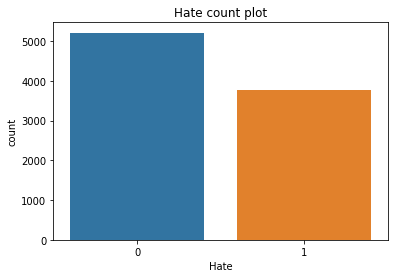

0    5213
1    3780
Name: Hate, dtype: int64

In [7]:
# create countplot for Target column
def createCP(df,x1):
    sns.countplot(x = x1, data = df)
    plt.title('Hate count plot')
    plt.show()

x = df.columns.tolist()[-1]   # last column is Target 'Hate''
createCP(df, "Hate")
df["Hate"].value_counts()

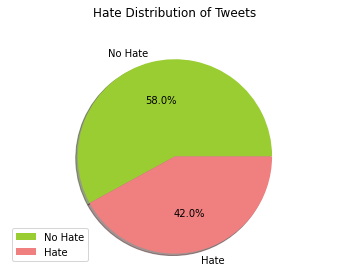

In [11]:
hate = [5213,3780]
colors_list = ['yellowgreen', 'lightcoral']
my_labels = 'No Hate','Hate'
plt.pie(hate,labels=my_labels,autopct='%1.1f%%',shadow=True,colors=colors_list)
plt.title('Hate Distribution of Tweets', y=1.12) 
plt.axis('equal') 
plt.legend(labels=my_labels, loc='lower left') 
plt.axis('equal')
plt.show()

**Treat Slangs in Tweet**

In order to treat slangs in tweets used abreviations from this link and created slangsdf CSV File: https://www.webopedia.com/reference/text-abbreviations/

In [14]:
slangs_df = pd.read_csv("/content/drive/MyDrive/slangsdf.csv")
slangs_df.head()

,Slangs,Fullforms
0,?,I have a question
1,?,I don’t understand what you mean
2,?4U,I have a question for you
3,;S,"Gentle warning, like “Hmm? What did you say?”"
4,^^,Meaning “read line” or “read message” above


In [15]:
def df_to_dict(df,df_dict):
    for index,row in df.iterrows():
        df_dict[row['Slangs']] = row['Fullforms']
    return df_dict

slangs_dict = {}
slangs_dict = df_to_dict(slangs_df,slangs_dict)
slangs_dict['PC'] = "Personal Computer"

def treat_slangs(row,slang_dict):
    words = row.split()
    treated_row = []
    reformed = []
    for word in words:
        if word.upper() in slang_dict.keys():
            new_word = word.replace(word,slang_dict[word.upper()])
            treated_row.append(new_word)
        else:
            treated_row.append(word)
    reformed = " ".join(treated_row)
    return reformed
df['Tweet'] = df['Tweet'].apply(lambda x:treat_slangs(x,slangs_dict))
df.head(2)

,Tweet,Hate
0,@user nice new signage. Acronym rich environme...,0
1,A woman who you fucked multiple times saying y...,1


**Treating Apostrophes/Contractions in Tweets**

In [16]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Tweet']=df['Tweet'].apply(lambda x:expand_contractions(x))
df.head(2)
df['Tweet'][0]

'@user nice new signage. Acronym rich environment you not concerned by Beatlemania -style hysterical crowds crongregating on you…'

**Preprocessing tweets by removing punctuations,urls etc. and Converting to lowercase**

In [17]:
import string
def clean_text(text):
    #convert the text to lower case
    text = text.lower()
    #remove @mention
    text = re.sub(r'@\w+', '', text)
    #remove Link word
    text = re.sub("{link}",'',text)
    #remove html tags
    text = re.sub("&[\w;]*",' ',text)
    #remove urls
    text = re.sub(r'http.?://[^\s]+[\s]?',' ',text)
    #remove RT
    text = re.sub(r'(?i)\bRT\b','',text)
    #remove content inside square brackets
    text = re.sub('\[.*?\]', ' ', text)
    #remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #remove digits
    text = re.sub('\d+', ' ',text)
    #remove new line character
    text= re.sub('\n', '', text)
    return text
df["Tweet"]= df.Tweet.apply(lambda x: clean_text(x))
df.Tweet.head(2)
df['Tweet'][0]

' nice new signage acronym rich environment you not concerned by beatlemania style hysterical crowds crongregating on you…'

**To remove Emojis, Referred code: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python**


In [18]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df["Tweet"]= df.Tweet.apply(lambda x: deEmojify(x))
df.Tweet.head(2)
df['Tweet'][0]

' nice new signage acronym rich environment you not concerned by beatlemania style hysterical crowds crongregating on you…'

**Remove StopWords**

In [19]:
import nltk
nltk.download('stopwords')
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain hate are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)
df["Tweet"]= df.Tweet.apply(lambda x: remove_stopwords(x))
df.Tweet.head(2)
df['Tweet'][0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'nice new signage acronym rich environment not concerned beatlemania style hysterical crowds crongregating you…'

**Lemmatization**

In [20]:
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
def lemmatization(input_text):
        words = input_text.split() 
        lemma = WordNetLemmatizer()
        lemma_words = [lemma.lemmatize(i) for i in words]
        return " ".join(lemma_words)
df["Tweet"]= df.Tweet.apply(lambda x: lemmatization(x))
df.Tweet.head(2)
df['Tweet'][0]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


'nice new signage acronym rich environment not concerned beatlemania style hysterical crowd crongregating you…'

(-0.5, 799.5, 499.5, -0.5)

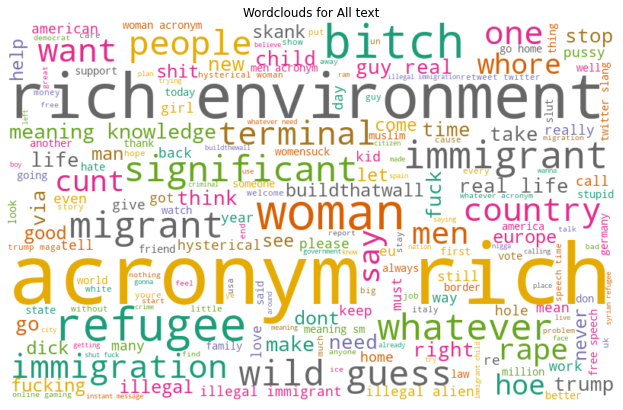

In [21]:
# Whole tweet wordcloud
all_words=' '.join(df['Tweet'])

# generate wordcloud object
wordcloud=WordCloud( background_color="white", colormap="Dark2",width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# plot wordcloud
plt.figure(figsize=(15,7))
plt.title('Wordclouds for All text')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [24]:
label=[0,1,2]
new_data={}
for t in label:
    new_data[t]= ' '.join(df[df.Hate.isin([t])].Tweet)
#new_data

In [25]:
#sentiment based DataFrame
train=pd.DataFrame(new_data.values(),index=new_data.keys(),columns=['Tweets'])
train.index=['Negative',' Neutral','Positive'] 
overall_train=train.copy()
overall_train

,Tweets
Negative,nice new signage acronym rich environment not ...
Neutral,woman fucked multiple time saying yo dick smal...
Positive,


In [26]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer 
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(train.Tweets)
data_dtm = pd.DataFrame(data_cv.toarray(), index=train.index,columns=cv.get_feature_names())
data_stop=data_dtm.T
data_stop

,Negative,Neutral,Positive
aaaawwww,1,0,0
aadhaar,1,0,0
aadhar,1,1,0
aag,0,1,0
aap,2,0,0
...,...,...,...
ˆðÿ,1,0,0
كك,0,1,0
كيك,0,1,0
ᴴᴰ,1,0,0


In [27]:
# Find the top 30 Trending words in each sentiments
top_dict = {}
for c in data_stop.columns:
    top = data_stop[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{' Neutral': [('rich', 639),
  ('environment', 624),
  ('acronym', 623),
  ('bitch', 556),
  ('woman', 547),
  ('refugee', 461),
  ('immigrant', 413),
  ('like', 314),
  ('migrant', 286),
  ('immigration', 278),
  ('illegal', 276),
  ('meaning', 254),
  ('terminal', 228),
  ('life', 227),
  ('people', 224),
  ('significant', 217),
  ('men', 210),
  ('cunt', 203),
  ('trump', 200),
  ('whore', 198),
  ('want', 195),
  ('rape', 193),
  ('guess', 193),
  ('wild', 184),
  ('country', 179),
  ('buildthatwall', 175),
  ('fuck', 170),
  ('guy', 165),
  ('time', 164),
  ('real', 162)],
 'Negative': [('rich', 961),
  ('environment', 947),
  ('acronym', 945),
  ('woman', 766),
  ('refugee', 711),
  ('immigrant', 641),
  ('bitch', 603),
  ('migrant', 427),
  ('like', 389),
  ('immigration', 377),
  ('significant', 332),
  ('people', 328),
  ('terminal', 319),
  ('men', 317),
  ('meaning', 312),
  ('illegal', 297),
  ('guess', 291),
  ('wild', 278),
  ('rape', 270),
  ('cunt', 261),
  ('country', 

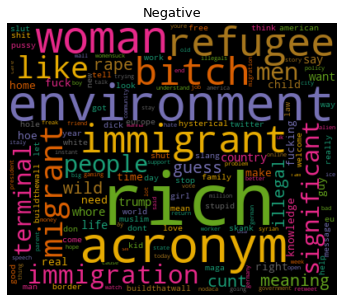

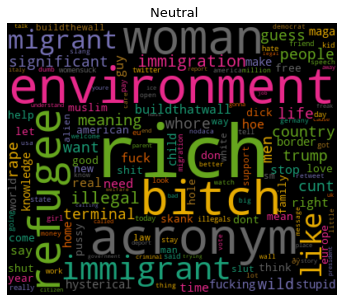

ZeroDivisionError: ignored

In [28]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(7,5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
data_stop

# Plotting word cloud for each product
for index,product in enumerate(data_stop.columns):
  generate_wordcloud(data_stop[product].sort_values(ascending=False),product)